In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import mean_squared_error

In [2]:
# Read CSV into a dataframe

# Setting the name of the Excel file which contains the solar generation data

file_name = 'PV_BY_Day.xlsx'

# Reading the Excel file using pandas. The engine 'openpyxl' is specified since it's a common engine for reading .xlsx files

df_generation = pd.read_excel(file_name, engine='openpyxl')

# Setting the name of the CSV file which contains the solar exposure data

file_name = 'IDCJAC0016_066207_1800_Data.csv'

# Reading the CSV file using pandas

df_exposure = pd.read_csv(file_name)

# Reading the 'totaldemand_nsw.csv' file into a dataframe

df_demand = pd.read_csv('totaldemand_nsw.csv', sep = ',', header = 0, parse_dates=['DATETIME'], dayfirst=True)

# Reading the 'temperature_nsw.csv' file into a dataframe

df_temp = pd.read_csv('temperature_nsw.csv', sep = ',', header = 0, parse_dates=['DATETIME'], dayfirst=True)

In [3]:
# Setting the name of the CSV files for the humidity data

file_name1 = 'humidity_wsp_20160916_20180729.xlsx'
file_name2 = 'humidity_wsp_20180730_20200610.xlsx'
file_name3 = 'humidity_wsp_20200611_20200930.xlsx'
file_name4 = 'humidity_wsp_20201001_20220731.xlsx'

# Reading the CSV files into dataframes

df_humidity_wsp1 = pd.read_excel(file_name1, engine='openpyxl')
df_humidity_wsp2 = pd.read_excel(file_name2, engine='openpyxl')
df_humidity_wsp3 = pd.read_excel(file_name3, engine='openpyxl')
df_humidity_wsp4 = pd.read_excel(file_name4, engine='openpyxl')

df_humidity_wsp = pd.concat([df_humidity_wsp1, df_humidity_wsp2, df_humidity_wsp3, df_humidity_wsp4], ignore_index=True)

In [4]:
# Define a list of strings which represent column names for a dataframe

column_names = ['date', 'time', 'wsp', 'humidity']

# Rename the columns of the 'df_humidity_wsp' dataframe

df_humidity_wsp.columns = column_names

In [5]:
# Convert 'date' column to datetime
df_humidity_wsp['date'] = pd.to_datetime(df_humidity_wsp['date'], format='%d/%m/%Y')
df_humidity_wsp['date'] = df_humidity_wsp['date'].dt.strftime('%Y-%m-%d')
                                         
# Group by 'date' and compute mean for 'wsp' and 'humidity'
agg_df_humidity_wsp = df_humidity_wsp.groupby('date').agg({'wsp': 'mean', 'humidity': 'mean'}).reset_index()

agg_df_humidity_wsp['date'] = pd.to_datetime(agg_df_humidity_wsp['date'], format='%Y-%m-%d')

In [6]:
#Filling in all nan humidity and wsp values with average for that date

agg_df_humidity_wsp['date'] = pd.to_datetime(agg_df_humidity_wsp['date'])

# Extract month and day from the date
agg_df_humidity_wsp['month'] = agg_df_humidity_wsp['date'].dt.month
agg_df_humidity_wsp['day'] = agg_df_humidity_wsp['date'].dt.day

# Calculate average values for wsp and humidity for each month-day combination
avg_values = agg_df_humidity_wsp.groupby(['month', 'day'])[['wsp', 'humidity']].mean().reset_index()

# Merge average values back to the original dataframe
agg_df_humidity_wsp = agg_df_humidity_wsp.merge(avg_values, on=['month', 'day'], suffixes=('', '_avg'))

# Replace NaN values with the average values
agg_df_humidity_wsp['wsp'].fillna(agg_df_humidity_wsp['wsp_avg'], inplace=True)
agg_df_humidity_wsp['humidity'].fillna(agg_df_humidity_wsp['humidity_avg'], inplace=True)

# Drop the auxiliary columns
agg_df_humidity_wsp.drop(columns=['month', 'day', 'wsp_avg', 'humidity_avg'], inplace=True)

In [7]:
# Extract the 'date' portion from the 'DATETIME' column of the 'df_demand' dataframe

df_demand['date'] = df_demand['DATETIME'].dt.date

# Convert the 'date' column in the 'df_demand' dataframe to a datetime format (from a date format)

df_demand['date'] = pd.to_datetime(df_demand['date'])

# Drop the first column (i.e., at index 0) of the 'df_demand' dataframe

df_demand = df_demand.drop(df_demand.iloc[:,0:1].columns, axis=1)

# Rename the 'TOTALDEMAND' column to 'total_demand' in the 'df_demand' dataframe

df_demand = df_demand.rename(columns={'TOTALDEMAND': 'total_demand'})

# Filter the 'df_demand' dataframe to only include rows where the 'date' is between 2016-09-16 and 2022-07-30 (inclusive)

df_demand = df_demand[df_demand['date'] < '2022-08-01']

df_demand = df_demand[df_demand['date'] >= '2016-09-16']

# Group the 'df_demand' dataframe by the 'date' column, summing the 'total_demand' for each date, and resetting the index

agg_df_demand = df_demand.groupby(['date'])['total_demand'].sum().reset_index()

In [8]:
# Extract the date portion from the 'DATETIME' column and store it in a new 'date' column.

df_temp['date'] = df_temp['DATETIME'].dt.date

# Convert the 'date' column from strings to datetime objects.

df_temp['date'] = pd.to_datetime(df_temp['date'])

# Drop the first column from the DataFrame

df_temp = df_temp.drop(df_temp.iloc[:,0:1].columns, axis=1)

# Rename the 'TEMPERATURE' column to 'temperature'.

df_temp = df_temp.rename(columns={'TEMPERATURE': 'temperature'})

# Filter the 'df_temp' dataframe to only include rows where the 'date' is between 2016-09-16 and 2022-07-30 (inclusive)

df_temp = df_temp[df_temp['date'] < '2022-08-01']
df_temp = df_temp[df_temp['date'] >= '2016-09-16']

# Group the DataFrame by 'date' and calculate the mean temperature for each date group.

agg_df_temp = df_temp.groupby(['date'])['temperature'].mean().reset_index()

In [9]:
# Group the DataFrame 'df_generation' by 'INTERVAL_DATETIME' and calculate the mean of 'GWh' for each group.

df_generation = df_generation.groupby('INTERVAL_DATETIME')['GWh'].mean().reset_index()

# Convert the 'INTERVAL_DATETIME' column to datetime objects by extracting only the date part.

df_generation['INTERVAL_DATETIME'] = pd.to_datetime(df_generation['INTERVAL_DATETIME'].dt.date)

# Define a list of column names.

column_names = ['date', 'solar_generation']

# Rename the columns of 'df_generation' using the defined column names.

df_generation.columns = column_names

# The date range for this project is 16/09/2016 - 01/08/2022. The next section filters the data to this scoped range.

df_generation = df_generation[df_generation['date'] < '2022-08-01']


# Group the filtered DataFrame by 'date' and calculate the sum of 'solar_generation' for each date group.

agg_df_generation = df_generation.groupby(['date'])['solar_generation'].sum().reset_index()

In [10]:
# Drop the first two columns from the DataFrame 'df_exposure'.

df_exposure = df_exposure.drop(df_exposure.columns[[0,1]], axis = 1)

# Define a list of column names.

column_names = ['year', 'month', 'day', 'daily_solar_exposure']

# Rename the columns of 'df_exposure' using the defined column names.

df_exposure.columns = column_names

# Create a new 'date' column by combining 'year', 'month', and 'day' columns into a datetime object.

df_exposure['date'] = pd.to_datetime(df_exposure[['year', 'month', 'day']])

# Filter the 'df_exposure' dataframe to only include rows where the 'date' is between 2016-09-16 and 2022-07-30 (inclusive)

df_exposure = df_exposure[df_exposure['date'] < '2022-08-01']
df_exposure = df_exposure[df_exposure['date'] >= '2016-09-16']

# There is one null daily_solar_exposure value on the 26th of November 2017. In order to fix this issue, we can use the average solar exposure for the 26th November.

avg_exposure = df_exposure[(df_exposure['month'] == 11) & (df_exposure['day'] == 26)]['daily_solar_exposure'].mean()
df_exposure.loc[(df_exposure['year'] == 2017) & (df_exposure['month'] == 11) & (df_exposure['day'] == 26), 'daily_solar_exposure'] = avg_exposure

# Dropping fields that are no longer required

df_exposure = df_exposure.drop(columns=['year', 'month', 'day'])

In [11]:
# Aggregating the Solar Generation Data to daily

agg_df_generation = df_generation.groupby(['date'])['solar_generation'].sum().reset_index()

In [12]:
# Joining datasets using outer joins on date

merged_df = agg_df_demand.merge(agg_df_temp, on='date', how='outer')\
              .merge(agg_df_generation, on='date', how='outer')\
              .merge(df_exposure, on='date', how='outer')\
              .merge(agg_df_humidity_wsp, on='date', how='outer')

In [13]:
# Only keep the columns 'date', 'total_demand', 'temperature', 'wsp', and 'humidity', 'solar_generation'

df = merged_df[['date', 'total_demand', 'temperature', 'wsp', 'humidity', 'solar_generation']]

# Add a new column 'day_of_year' to the 'df' DataFrame, which extracts the day of the year from the 'date' column.

df['day_of_year'] = df['date'].dt.dayofyear

In [14]:
# Calculate a normalized 'day_of_year' value in the range [0, 2*pi].
df["day_of_year_norm"] = 2 * math.pi * df["day_of_year"] / df["day_of_year"].max()

# Calculate the cosine of the normalized 'day_of_year_norm' values and store them in a new column 'day_of_year_cos'.

df["day_of_year_cos"] = np.cos(df["day_of_year_norm"])

# Calculate the sine of the normalized 'day_of_year_norm' values and store them in a new column 'day_of_year_sin'.

df["day_of_year_sin"] = np.sin(df["day_of_year_norm"])

In [15]:
# Store the dates before removing the column
date_values = df['date'] 

# Only keep the columns 'total_demand', 'temperature', 'wsp','humidity', 'day_of_year_cos', 'day_of_year_sin', 'solar_generation'
df = df[['total_demand', 'temperature', 'wsp', 'humidity', 'day_of_year_cos', 'day_of_year_sin', 'solar_generation']]

In [16]:
# Setting the seed for reproducibility
seed_value = 5152
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [17]:
# Split the DataFrame 'df' into training and temporary DataFrames 'train_df' and 'temp_df'.
# The training set will contain 60% of the data, and the temporary set will contain 40%.
train_df, temp_df = train_test_split(df, test_size=0.4, shuffle=False)

# Split the temporary DataFrame 'temp_df' into validation and test DataFrames 'valid_df' and 'test_df'.
# The validation set will contain 20% of the original data, and the test set will contain the remaining 20%.
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=False)

# Split the list of dates 'date_values' in the same manner as the data.
# This ensures that the dates correspond to the respective subsets of data.
# The training, validation, and test dates are stored in 'temp_dates' and 'test_dates'.
_, temp_dates = train_test_split(date_values, test_size=0.4, shuffle=False)
_, test_dates = train_test_split(temp_dates, test_size=0.5, shuffle=False)

In [18]:
# Normalization

# Create an instance of the MinMaxScaler

scaler = MinMaxScaler()

# Normalize the 'train_df' dataset and store the result in the 'train' variable.
# The 'fit_transform' method scales the data and also computes the scaling parameters based on the training data.

train = scaler.fit_transform(train_df)

# Normalize the 'valid_df' dataset using the scaling parameters learned from the training data.

valid = scaler.transform(valid_df)

# Normalize the 'test_df' dataset using the same scaling parameters learned from the training data.

test = scaler.transform(test_df)

In [19]:
# Setting optimized parameters
learning_rate_opt = 0.008164246632249867
look_back_opt = 43
batch_size_opt = 40
activation_opt = 'tanh'

In [20]:
# Function to create datasets for LSTM

def create_dataset(dataset, look_back=10):

    # Initialize empty lists to store sequences of input features (dataX) and target values (dataY).
    
    dataX, dataY = [], []

    # Iterate through the dataset to create sequences.

    for i in range(len(dataset)-look_back-1):
        
        # Extract a subsequence of 'look_back' time steps from the dataset.
        
        a = dataset[i:(i+look_back), :]
        
        # Append the subsequence to the 'dataX' list.        
        
        dataX.append(a)
        
        # Append the next time step's value (target) to the 'dataY' list.
        # The target value is taken from the next time step after the 'look_back' window.     
        
        dataY.append(dataset[i + look_back, 0])
        
    # Convert the lists of sequences into numpy arrays and return them.        

    return np.array(dataX), np.array(dataY)

In [21]:
# Build LSTM Model
def build_lstm_model(learning_rate, look_back, activation, batch_size):

    # Create training and validation datasets using the 'create_dataset' function.
    
    trainX, trainY = create_dataset(train, look_back)
    validX, validY = create_dataset(valid, look_back)

    # Create a Sequential model.
    
    model = Sequential()
    
    # Add an LSTM layer with 50 units and specify the input shape.
    
    model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
    
    # Add an activation function (specified by the 'activation' parameter).    
    
    model.add(Activation(activation))
    
    # Add a Dense layer with a single output unit for regression.    
    
    model.add(Dense(1))
    
    # Define the optimizer with the given learning rate.
    
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with mean squared error (MSE) as the loss function and the specified optimizer.
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    # Return the model and the training/validation data for further training and evaluation.    
    
    return model, trainX, trainY, validX, validY

In [22]:
num_runs = 100
all_predictions = []

# Loop for a specified number of runs (num_runs)

for run in range(num_runs):
    
    # Set random seeds for NumPy and TensorFlow to ensure reproducibility.
    
    np.random.seed(seed_value + run)
    tf.random.set_seed(seed_value + run)
    
    # Build an LSTM model with specified hyperparameters and obtain training and validation data.    
    
    model, trainX, trainY, validX, validY = build_lstm_model(learning_rate_opt, look_back_opt, activation_opt, batch_size_opt)
    
    # Set up early stopping  
    
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    # Train the model with training data and validation data, using early stopping.    
    
    model.fit(trainX, trainY, epochs=1000, batch_size=batch_size_opt, validation_data=(validX, validY), verbose=1, callbacks=[early_stop])
    
    # Create a test dataset with the same look_back parameter.    
    
    testX, testY = create_dataset(test, look_back_opt)
    
    # Make predictions on the test dataset.    
    
    test_predictions = model.predict(testX)
    
    # Append the test predictions from this run to the 'all_predictions' list.    
    
    all_predictions.append(test_predictions)

# Calculate the average of predictions from all runs (an ensemble prediction).

avg_predictions = np.mean(np.array(all_predictions), axis=0)

# Inverse transform the scaled predictions to obtain predictions in the original scale.

avg_predictions_original = scaler.inverse_transform(np.concatenate((avg_predictions, testX[:,0,1:]), axis=1))[:,0]

# Adjust the test dates to account for the look_back offset.
test_dates = test_dates[look_back_opt+1:].values

Epoch 1/1000
32/32 [==============================] - 2s 22ms/step - loss: 0.0370 - val_loss: 0.0175
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0170 - val_loss: 0.0114
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0151 - val_loss: 0.0110
Epoch 4/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0150 - val_loss: 0.0102
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0142 - val_loss: 0.0093
Epoch 6/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.0127 - val_loss: 0.0095
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.0098
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0132 - val_loss: 0.0099
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 10/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0109 - val_lo

Epoch 27/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 28/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 29/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0081
Epoch 30/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 31/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0119
Epoch 32/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0142
Epoch 33/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 34/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 35/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0108
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100

Epoch 48/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0084
Epoch 49/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0064
Epoch 50/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 51/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 52/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 53/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 54/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 55/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 56/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 57/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0066

32/32 [==============================] - 0s 11ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 4/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0147 - val_loss: 0.0109
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0139 - val_loss: 0.0103
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0128 - val_loss: 0.0090
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0100
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0080
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0085
Epoch 10/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.0080
Epoch 11/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 12/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0139


32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 32/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 33/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 34/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 35/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0081
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 40/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 10/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 11/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 12/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 13/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 14/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 15/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 16/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 17/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0114 - val_loss: 0.0082
Epoch 18/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0094
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0090
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0077
Epoch 40/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0108
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0104
Epoch 42/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0091 - val_loss: 0.0100
Epoch 43/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 44/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 37/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0070
Epoch 38/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 39/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 40/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 41/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 42/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 43/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 44/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0072
Epoch 45/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0

13/13 [==============================] - 0s 4ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0331 - val_loss: 0.0128
Epoch 2/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0166 - val_loss: 0.0115
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.0121
Epoch 4/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0134 - val_loss: 0.0177
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0146 - val_loss: 0.0181
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0097
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0084
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0172
Epoch 10/1000
32/32 [=================

32/32 [==============================] - 0s 11ms/step - loss: 0.0097 - val_loss: 0.0085
Epoch 24/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0103
Epoch 25/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0087
Epoch 26/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 27/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0364 - val_loss: 0.0139
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0174 - val_loss: 0.0119
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0154 - val_loss: 0.0123
Epoch 4/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0140 - val_loss: 0.0102
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0130 - val_loss: 0.0163
Epoch 6/1000
32/32 [==============

32/32 [==============================] - 0s 12ms/step - loss: 0.0194 - val_loss: 0.0176
Epoch 3/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0180 - val_loss: 0.0144
Epoch 4/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0149 - val_loss: 0.0108
Epoch 5/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 7/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0133 - val_loss: 0.0103
Epoch 8/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0129 - val_loss: 0.0090
Epoch 9/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 10/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0135 - val_loss: 0.0105
Epoch 11/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0114 - val_loss: 0.0089
E

32/32 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 50/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 51/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0091
Epoch 52/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 53/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 54/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 55/1000
13/13 [==============================] - 0s 4ms/step
Epoch 1/1000
32/32 [==============================] - 2s 21ms/step - loss: 0.0450 - val_loss: 0.0279
Epoch 2/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0182 - val_loss: 0.0148
Epoch 3/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0161 - val_loss: 0.0120
Epoch 4/1000
32/32 [============

32/32 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 39/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 40/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0087
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 42/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 43/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 44/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 45/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 46/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0090
Epoch 47/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0076 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 49/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0088
Epoch 50/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 51/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0096
Epoch 52/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 53/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 54/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 55/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 56/1000
13/13 [==============================] - 0s 4ms/step
Epoch 1/1000
32/32 [==============================] - 2s 21ms/step - loss: 0.0383 - val_loss: 0.0141
Epoch 2/1000
32/32 [==========

32/32 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0113
Epoch 32/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 33/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 34/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0089 - val_loss: 0.0068
Epoch 35/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 36/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0080 - val_loss: 0.0117
Epoch 37/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 38/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 39/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 40/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 59/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0067 - val_loss: 0.0076
Epoch 60/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 61/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 62/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 63/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0082
Epoch 64/1000
13/13 [==============================] - 0s 4ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0301 - val_loss: 0.0148
Epoch 2/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0154
Epoch 3/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0147 - val_loss: 0.0126
Epoch 4/1000
32/32 [============

32/32 [==============================] - 0s 11ms/step - loss: 0.0106 - val_loss: 0.0084
Epoch 16/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 17/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0088
Epoch 18/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0113
Epoch 19/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 20/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 21/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 22/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 23/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0098
Epoch 24/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 24/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 25/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 26/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 27/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 28/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 29/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 30/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 31/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 32/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 48/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 49/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 50/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 51/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0.0101
Epoch 52/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 53/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 54/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 55/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 56/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0

Epoch 23/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 24/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 25/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 26/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 27/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 28/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 29/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0076
Epoch 30/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 31/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 32/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0088

Epoch 33/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 34/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0069
Epoch 35/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0070
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 40/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0090
Epoch 42/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0111

32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 44/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 45/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 46/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0073
Epoch 47/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 48/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 49/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 50/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 51/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 52/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 28/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 29/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 30/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 31/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0078 - val_loss: 0.0092
Epoch 32/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 33/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 34/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 35/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 65/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 66/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 67/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0575 - val_loss: 0.0352
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0202 - val_loss: 0.0170
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0164 - val_loss: 0.0205
Epoch 4/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0150 - val_loss: 0.0121
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0145 - val_loss: 0.0123
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0137 - val_loss: 0.0126
Epoch 7/1000
32/32 [===============

32/32 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0.0093
Epoch 24/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 25/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 26/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 27/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0131
Epoch 28/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 29/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0083
Epoch 30/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 31/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 32/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0086 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 47/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0066
Epoch 48/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 49/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 50/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 51/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 52/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 53/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0324 - val_loss: 0.0203
Epoch 2/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0160 - val_loss: 0.0181
Epoch 3/1000
32/32 [===========

32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 51/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 52/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 53/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 54/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 55/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 56/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 57/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 58/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 59/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0072 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 60/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0472 - val_loss: 0.0278
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0198 - val_loss: 0.0157
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0161 - val_loss: 0.0108
Epoch 4/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0154 - val_loss: 0.0181
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0123
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.0162
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 9/1000
32/32 [=================

32/32 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 22/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 23/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 24/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 25/1000
13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0346 - val_loss: 0.0138
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0173 - val_loss: 0.0129
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0156 - val_loss: 0.0146
Epoch 4/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0153 - val_loss: 0.0098
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 6/1000
32/32 [==============

32/32 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 40/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 42/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0076
Epoch 43/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 44/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0109
Epoch 45/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 34/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 35/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0062
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 40/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 42/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0085 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0103 - val_loss: 0.0084
Epoch 15/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0101 - val_loss: 0.0160
Epoch 16/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 17/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0080
Epoch 18/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 19/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0083
Epoch 20/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 21/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 22/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 23/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0103 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0101
Epoch 8/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0106 - val_loss: 0.0112
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0114 - val_loss: 0.0101
Epoch 10/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 11/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 12/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0101
Epoch 13/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 14/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 15/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 16/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0

32/32 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 27/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 28/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 29/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 30/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 31/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 32/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 33/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 34/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 35/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0

13/13 [==============================] - 0s 3ms/step
Epoch 1/1000
32/32 [==============================] - 2s 20ms/step - loss: 0.0285 - val_loss: 0.0183
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0143
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 4/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0139
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0136 - val_loss: 0.0131
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0127 - val_loss: 0.0097
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0114 - val_loss: 0.0095
Epoch 8/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 9/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 10/1000
32/32 [=================

32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 63/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 64/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 65/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0091
Epoch 66/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 67/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0084 - val_loss: 0.0093
Epoch 68/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 69/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 70/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 71/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0

32/32 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 33/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0095 - val_loss: 0.0105
Epoch 34/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 35/1000
32/32 [==============================] - 0s 14ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 36/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 37/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 38/1000
32/32 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 39/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 40/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 41/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 52/1000
13/13 [==============================] - 0s 4ms/step
Epoch 1/1000
32/32 [==============================] - 2s 21ms/step - loss: 0.0437 - val_loss: 0.0151
Epoch 2/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0173 - val_loss: 0.0137
Epoch 3/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0154 - val_loss: 0.0109
Epoch 4/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0156 - val_loss: 0.0128
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0147 - val_loss: 0.0100
Epoch 6/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 7/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0140 - val_loss: 0.0092
Epoch 8/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0120 - val_loss: 0.0097
Epoch 9/1000
32/32 [=================

32/32 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0115
Epoch 33/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 34/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0067
Epoch 35/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0076 - val_loss: 0.0104
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 40/1000
32/32 [==============================] - 0s 12ms/step - loss: 0.0076 - val_loss: 0.0091
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0

32/32 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0111
Epoch 35/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 36/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 37/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 38/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 39/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 40/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 41/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 42/1000
13/13 [==============================] - 0s 3ms/step


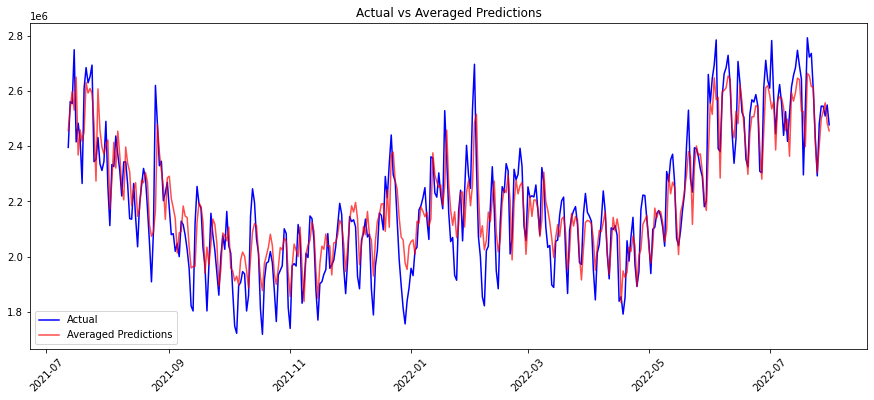

MAPE for Averaged Predictions: 3.64%


In [23]:
# Averaging Ensemble Predictions
avg_predictions = np.mean(np.array(all_predictions), axis=0)
avg_predictions_original = scaler.inverse_transform(np.concatenate((avg_predictions, testX[:,0,1:]), axis=1))[:,0]

# Inverse transform for the actual values
testY_original = scaler.inverse_transform(np.concatenate((testY.reshape(-1,1), testX[:,0,1:]), axis=1))[:,0]

# Plot Actual vs Averaged Predictions with Dates
plt.figure(figsize=(15,6))
plt.plot(test_dates, testY_original, label='Actual', color='blue')
plt.plot(test_dates, avg_predictions_original, label='Averaged Predictions', color='red', alpha=0.7)
plt.title('Actual vs Averaged Predictions')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Define MAPE function

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE

mape = mean_absolute_percentage_error(testY_original, avg_predictions_original)
print(f"MAPE for Averaged Predictions: {mape:.2f}%")

In [24]:
# Create a DataFrame with 'date', 'actual', and 'average predicted' fields
output_df = pd.DataFrame({
    'date': test_dates,
    'actual': testY_original,
    'average_predicted': avg_predictions_original
})

# Export the DataFrame to Excel
output_df.to_excel('predictions_output_withsolar.xlsx', index=False)